<h1>Preparation and Overview</h1>
<h2>Preparation</h2>
The data preparation procedure we chose for this lab is similar to that of lab 1. We began with a mostly complete dataset, which has many features which are unnecessary for the classification task. We took the following steps to clean the data and prepare it for our use case: <br>
1. We first got rid of duplicate rows. We can reliably do this without a unique identifier because there are sufficiently many features to confidently say that exact duplicates of data are most likely a duplicate entry.<br>
2. We then removed any data with an unknown prediction class, whether the unknown class is due to the pitch being unidentifiable, or because the overview does not contain the translation from abreviated label to actual prediction class.<br>
3. Next, we removed outlier in the data. While this is not an exact science, we believe that the heuristic we used sufficiently cleans outliers out of the data without compromising the integrity of the data.<br>
4. Finally, we removed any data points where the ground truth cannot be 100% trusted. Our dataset included a measure of confidence in the label assigned to each data point. We removed any data points where the confidence was below a threshold of 1 (out of 2).<br>
<h2>Overview</h2>
This data is an interesting, yet unsurprising find. Baseball is one of the most statistics-driven professional sports in the world. Nearly every happening on the field is quantified and logged for further analysis. This logging is useful for both the clubs competing in a match, and also to the entities responsible for the broadcasts. Effortless data analytics can enhance a broadcast and help enhance the viewer's understanding of the game.<br>
With some preprocessing, broadcast networks can turn real-time images from the contest into data that a machine learning model can use to predict what sort of pitch was thrown. This information is useful for 2 main reasons. A casual fan trying to have a deeper understanding of the game can follow along more easily with a real-time indication of what's happening at a high level of the game. In kind, broadcasters and clubs can use this data to better understand trends in the opposition and their own clubs alike. While it is possible for a human to do this tedious work, automating it will cut down on mistakes, and allow real-time display, or real-time data analytics.

<h2>Class Variables</h2>

The dataset consists of 39 attributes and 15 prediction classes describing the information of the pitch thrown. Of these 39 attributes, we have chosen 5 attributes that are most likely candidates to use for the classification task. These are:

1. Break length - Float
2. Break angle - Float
3. Start Speed - Float
4. End Speed and - Float
5. Spin rate - Float

The prediction class is represented as a string object denoting the type of pitch - in classification we will turn this data into a series of binary one-vs-all data. <br>
We took a hierarchical approach towards the classification problem by clustering the prediction classes into three super classes, namely:

1. Fast pitches (FC – Cutter, FF – Four Seam Fastball, FS – Splitter, FT – Two Seam Fastball,SI – Sinker)
2. Breaking Balls ( CU – Curveball, KC – Knuckle Curve, KN – Knuckleball, SL – Slider, SC - Screwball)
3. Slow Pitches ( CH – Changeup, EP – Eephus, FO – Pitchout, PO – Pitchout, IN – Intentional Ball )


In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('../pitches.csv')

In [2]:
#drop unkown prediction classes and prediction classes with no definition from data source
df.drop_duplicates(inplace=True)
df = df[df.pitch_type != 'UN']
df = df[df.pitch_type != 'FA']

features = ['break_angle', 'break_length', 'end_speed', 'start_speed', 'spin_rate', 'pitch_type']
#remove wild pitches or intentional walks as break length outliers. Code sourced from https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame
for feature in features:
    if feature != 'pitch_type':
        df = df[np.abs(df[feature]-df[feature].mean()) <= (12*df[feature].std())]

#drop data points where prediction class is unreliable
df = df[df.type_confidence >= 1.0]

#Drop any data with incomplete records
df.dropna(inplace=True)

In [3]:
#Summary Statistics For Each Feature in the Feature Vector
desc = df[features].groupby('pitch_type').describe()
pd.options.display.max_columns = None

# for feature in features:
#     if feature != 'pitch_type':
#         print(feature)
#         display(desc[feature])

In [4]:
#separate pitches based on prediction class for visualization
# What might be a reasonable value for bounding break_length ? I picked 100.0
df = df[df.break_length <= 100.0] 
fast_pitches_super_group = df[df.pitch_type.isin(['FC','FF','FS','FT','SI'])]
fast_pitches_super_group['grouping'] = 'fast_ball'
breaking_pitches_super_group = df[df.pitch_type.isin(['CU', 'KC', 'KN', 'SL', 'SC'])]
breaking_pitches_super_group['grouping'] = 'breaking_ball'
slow_pitches_super_group = df[df.pitch_type.isin(['CH','EP','FO','PO','IN'])]
slow_pitches_super_group['grouping'] = 'slow_ball'
visualization_frames = [fast_pitches_super_group, breaking_pitches_super_group, slow_pitches_super_group]
df = pd.concat(visualization_frames).sample(frac=1)

/home/rasimon/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/rasimon/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/rasimon/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/panda

In [5]:
#reduce dimensions to 3 most important
df_scaled = df[['break_length','break_angle','start_speed', 'end_speed','spin_rate']].head(3000)

from sklearn.decomposition import KernelPCA
pca = KernelPCA(n_components=3)
pca.fit(df_scaled) # fit data and then transform it
X_pca = pca.transform(df_scaled)

# print the components

# print ('pca:', pca.components_)

<h2> 2.0 Data Modelling </h2> <br>In Assignment-1, it has been observed that the three classes in the dataset can be well separated by reducing the dimensions from 6 to 3 using PCA. It appeared that the data is separable on a 3-dimensional surface. So, we provide perform dimensionality reduction using PCA to reduce the data to 3 dimensions. We hope to separate the data using logistic regression in 3-dimensions. Logistic regression separates the data by dividing them into hyperplanes. So, we may only be able to approximately classify the data as we cannot separate the data using 3D classifying surface

In [6]:
from scipy.special import expit
class BinaryLogisticRegressionBase:
    def __init__(self, eta, iterations=20, kernel = 0, C=0.001):
        self.eta = eta
        self.iters = iterations
        self.C = C
        if kernel != 0:
            self.kernel = kernel
        else:
            self.kernel = '_get_gradient'
    def __str_(self):
        return "Base Logistic Regression object, Not Trainable"
    @staticmethod
    def _sigmoid(theta):
        return expit(theta)
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0], 1)),X))
    def predict_proba(self,X,add_bias=True):
        if hasattr(self,'w_'):
            Xb = self._add_bias(X) if add_bias else X
            return self._sigmoid(Xb @ self.w_)
        else:
            raise("Predictin with Untrained Logistic Regression Object")
    def predict(self,X):
        return (self.predict_proba(X)>0.5)

<h3>2.1 L1 Regularization</h3>
<br>
L1-Norm parameter is added to the equation. The idea is to keep the values of the weights relatively small. This helps to control overfitting to the data. For L1 Regularization or Lasso-regularization, the cost function is updated by the sum of weights.

$$ l(\mathbf{w})_{reg} = l(\mathbf{w})_{old} + C\cdot\sum_j w_j $$

This means the gradient will be updated as follows:

$$ \mathbf{w} \leftarrow \mathbf{w} + \eta \left[\underbrace{\nabla l(\mathbf{w})_{old}}_{\text{old gradient}} + sign(\mathbf{w})C \right]$$


In [7]:
from numpy.linalg import inv, pinv
class BinaryLogisticRegression(BinaryLogisticRegressionBase):
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'BLR Object with coefficients: \n' + str(self.w_)
        else:
            return 'Untrained BLR Object'
    def _get_gradient(self, X, y):
        ydiff = y-self.predict_proba(X,add_bias=False).ravel()
        gradient=np.mean(X*ydiff[:,np.newaxis],axis=0)
        return gradient.reshape(self.w_.shape)
    def _steepest_descent_L2(self,X,y):
        ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += -2 * self.w_[1:] * self.C
        
        return gradient
    
    def _steepest_descent_L1(self,X,y):
        ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += np.sign(self.w_[1:]) * self.C
        
        return gradient
    
    def _stochastic_descent_L2(self,X,y):
        idx = int(np.random.rand()*len(y)) # grab random instance
        ydiff = y.iat[idx]-self.predict_proba(X[idx],add_bias=False) # get y difference (now scalar)
        gradient = X[idx] * ydiff[:,np.newaxis] # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += -2 * self.w_[1:] * self.C
        
        return gradient 
    
    def _stochastic_descent_L1(self,X,y):
        idx = int(np.random.rand()*len(y)) # grab random instance
        ydiff = y.iat[idx]-self.predict_proba(X[idx],add_bias=False) # get y difference (now scalar)
        gradient = X[idx] * ydiff[:,np.newaxis] # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += np.sign(self.w_[1:]) * self.C
        
        return gradient     

    def _newton_method_L2(self,X,y):
        g = self.predict_proba(X,add_bias=False).ravel() # get sigmoid value for all classes
        hessian = X.T @ np.diag(g*(1-g)) @ X - 2 * self.C # calculate the hessian

        ydiff = y-g # get y difference
        gradient = np.sum(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += -2 * self.w_[1:] * self.C
        
        return pinv(hessian) @ gradient
    
    def _newton_method_L1(self,X,y):
        g = self.predict_proba(X,add_bias=False).ravel() # get sigmoid value for all classes
        hessian = X.T @ np.diag(g*(1-g)) @ X - 2 * self.C # calculate the hessian

        ydiff = y-g # get y difference
        gradient = np.sum(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += np.sign(self.w_[1:]) * self.C
        
        return pinv(hessian) @ gradient  
    def _steepest_descent_MSE_L2(self,X,y):
        sigmoid_out = self.predict_proba(X,add_bias=False).ravel()
        pdt = (y-sigmoid_out) * (sigmoid_out * (1 - sigmoid_out))
        gradient = np.mean(X * pdt[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += -2 * self.w_[1:] * self.C
        
        return gradient

    def _steepest_descent_MSE_L1(self,X,y):
        sigmoid_out = self.predict_proba(X,add_bias=False).ravel()
        pdt = (y-sigmoid_out) * (sigmoid_out * (1 - sigmoid_out))
        gradient = np.mean(X * pdt[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += np.sign(self.w_[1:]) * self.C
        
        return gradient 
    
    def _newton_method_MSE_L1(self,X,y):
        g = self.predict_proba(X,add_bias=False).ravel() # get sigmoid value for all classes
        hessian = X.T @ np.diag(-1*g*(1-g)*(y - 2*g*(1 + y) + 3*g*g)) @ X - 2 * self.C # calculate the hessian
        pdt = (y-g) * (g * (1 - g))
        gradient = np.mean(X * pdt[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += np.sign(self.w_[1:]) * self.C
        
        return pinv(hessian) @ gradient 
    def fit(self, X, y):
        Xb = self._add_bias(X)
        num_samples, num_features = Xb.shape
    
        self.w_ = np.zeros((num_features, 1))
    
        for _ in range(self.iters):
            gradient = getattr(self, self.kernel)(Xb,y)
            self.w_ += gradient*self.eta

In [8]:
class MultiClassLogisticRegression:
    def __init__(self, eta, iterations=20, kernel=0, C=0.001):
        self.eta = eta
        self.iters = iterations
        self._classifiers = {}
        if kernel != 0:
            self.kernel = kernel
        else:
            self.kernel = '_get_gradient'
        self.C = C
    def fit(self, X, y):
        unique = y.unique()
        for label in unique:
            label_train = (y == label).astype(np.int)
            bin_classifier = BinaryLogisticRegression(self.eta, self.iters, self.kernel, self.C)
            bin_classifier.fit(X, label_train)
            self._classifiers[label] = bin_classifier
    def predict(self, X):
        max_prob = np.zeros(X.shape[0])
        key = np.empty(X.shape[0], dtype=object)
        for k, v in self._classifiers.items():
            prob = v.predict_proba(X)
            for x in range(X.shape[0]):
                if prob[x] > max_prob[x]:
                    key[x] = k
        return key
            
        

<h2> 2.2 Train Test Split </h2> <br>
Train/Test splitting is done in 80/20 ration. 80/20 split is appropriate for the dataset because the pitches are not ordered in a sequence in the dataset. The data distribution is random and hence 80/20 split would accurately represent the data distribution.

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import time
from matplotlib.pyplot import figure
from random import randint
import pandas as pd
kernels = ['_stochastic_descent_L1', '_stochastic_descent_L2', '_steepest_descent_L1', '_steepest_descent_L2', '_newton_method_L1', '_newton_method_L2'
          , '_steepest_descent_MSE_L2', '_steepest_descent_MSE_L1', '_newton_method_MSE_L1']
sklearn_kernels = ['newton-cg', 'lbfgs', 'sag', 'saga']
accuracies = []
C_list = []
times = []
best = 0
best_settings = ()
for idx, kernel in enumerate(kernels):
    usr_accuracies = []
    usr_time = []
    
    for _ in range(10):
        C = 0.001 * randint(1, 100)
        eta = 0.001 * randint(1, 100)
        iterations = randint(1000, 3000)
        
        X_train, X_test, y_train, y_test = train_test_split(X_pca, df.grouping.head(3000),
                                             test_size=.2, random_state=42)
        
        if kernel == '_newton_method_L1' or kernel == '_newton_method_L2' or kernel == '_newton_method_MSE_L1':
            mc = MultiClassLogisticRegression(10000, 1, kernel, C)
        elif kernel == '_stochastic_descent_L1' or kernel == '_stochastic_descent_L2':
            mc = MultiClassLogisticRegression(eta, iterations, kernel, C)
        elif kernel == '_steepest_descent_L1' or kernel == '_steepest_descent_L1' or kernel == '_steepest_descent_MSE_L1':
            mc = MultiClassLogisticRegression(eta, iterations, kernel, C)
        else:
            mc = MultiClassLogisticRegression(.4, 1000, kernel)
                                          
        start = time.time()
        mc.fit(X_train, y_train)
        res = mc.predict(X_test)
        end = time.time()
        correct = res[res == y_test]
        usr_time.append(end - start)
        usr_accuracies.append(len(correct)/len(y_test)*100)
        C_list.append((C, len(correct)/len(y_test) * 100 ))
        if len(correct)/len(y_test) * 100 > best:
            best = (len(correct)/len(y_test) * 100)
            best_settings = (C, eta, iterations, kernel, len(correct)/len(y_test) * 100)
                                              
        
    accuracies.append(sum(usr_accuracies)/len(usr_accuracies))
    times.append(sum(usr_time)/len(usr_time))
    
    
x_pos = [i for i, _ in enumerate(kernels)]
x_times =[i for i, _ in enumerate(times)]
print('Best C:', best_settings[0])
print('Best Eta:', best_settings[1])
print('Best Iterations:', best_settings[2])
print('Best Kernel:', best_settings[3])
print('Best Accuracy', best_settings[4])



sk_times = []
sk_total = []
for idx, kernel in enumerate(sklearn_kernels):
    sk_instance_time = []
    sk_accuracies = []
    for _ in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X_pca, df.grouping.head(3000),
                                                   test_size=.2, random_state=42)
        start = time.time()
        clf = LogisticRegression(random_state=0, solver=kernel, multi_class='multinomial', max_iter = 3000).fit(X_train, y_train)
        res = clf.predict(X_test)
        end = time.time()

        correct = res[res == y_test]
        sk_accuracies.append(len(correct)/len(y_test)*100)
        sk_instance_time.append(end - start)
    sk_total.append(sum(sk_accuracies)/len(sk_accuracies))
    sk_times.append(sum(sk_instance_time)/len(sk_instance_time))
sk_x_pos = [i for i, _ in enumerate(sklearn_kernels)]
sk_x_times =[i for i, _ in enumerate(sk_times)]

Best C: 0.02
Best Eta: 0.037
Best Iterations: 2771
Best Kernel: _newton_method_L1
Best Accuracy 79.33333333333333


<h2>Optimization Technique and Regularizaion</h2>


<h2>2.3 Optimization Technique and Regularizaion</h2> <br>

In the optimization technique, we have implemented the steepest descent, stochastic descent and Newton's method with each having an L1, L2 regularization options. Contrasting the method with Scikit learn implementations, the Scikit learn approach doesn't take the number of iterations as an input and automatically stops after converging. It is not the case with Newton's method though as the Newton's method is designed to converge within a single step.
To best select a candidate kernel function for our logistic regression, we trialed a few of them to test for accuracy and training time when comapred to scikit-learn.<br>
Our best performing kernel ended up being L1 regularization Newton's Method. The best values of the parameters used for the optimimal classification are listed above. Unsurprisingly, the best classification occurred with a high number of iterations, a low learning rate, and a relatively high regularization. This allows for gradual gradient descent over many iterations, while avoiding overfitting.<br>
In this case, our best accuracy was 79%. This is slightly behind that of scikit-learn, which is getting around 84% accuracy. This is for a few reasons. Most significantly, sklearn tests for convergence in their implementations. That is, the algorithm will run until a minimum is reached. Our naive implementation will not, and will run for exaclty the number of iterations specified. This means that some loss can be accounted for due to the imperfect number of iterations being performed. Similarly, sklearn can optimize for values of C and eta. This allows for a more effective learning rate and regularization, which will also make their classifier slightly more accurate. 

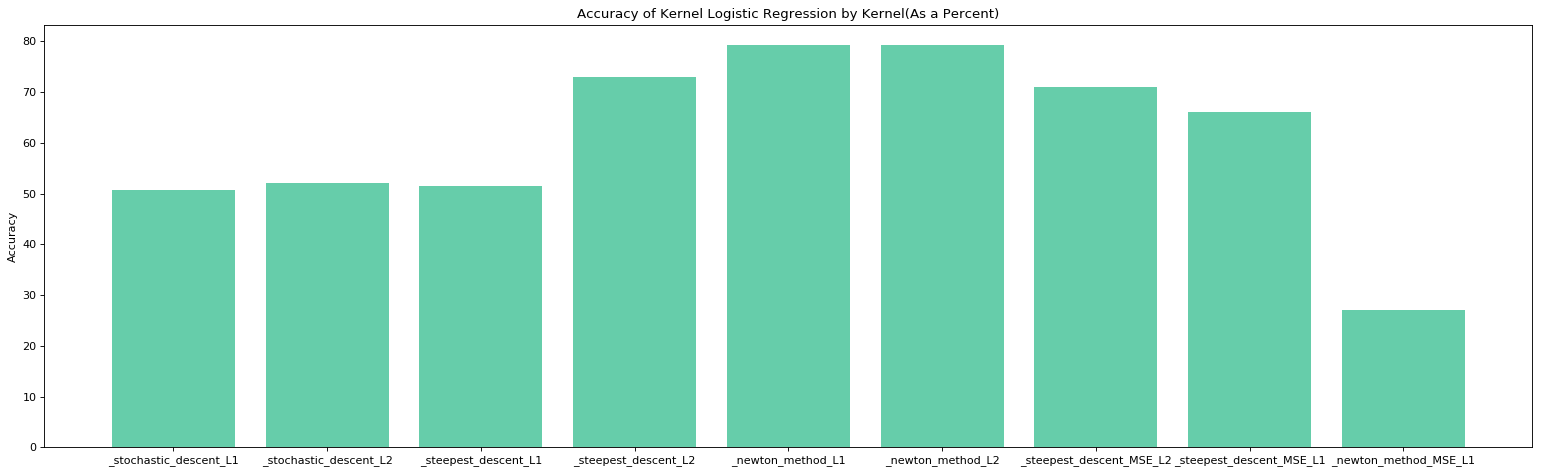

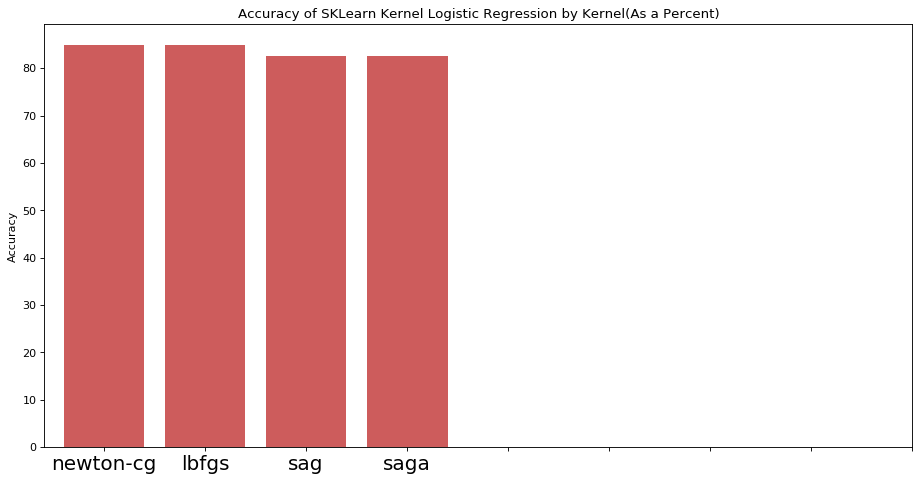

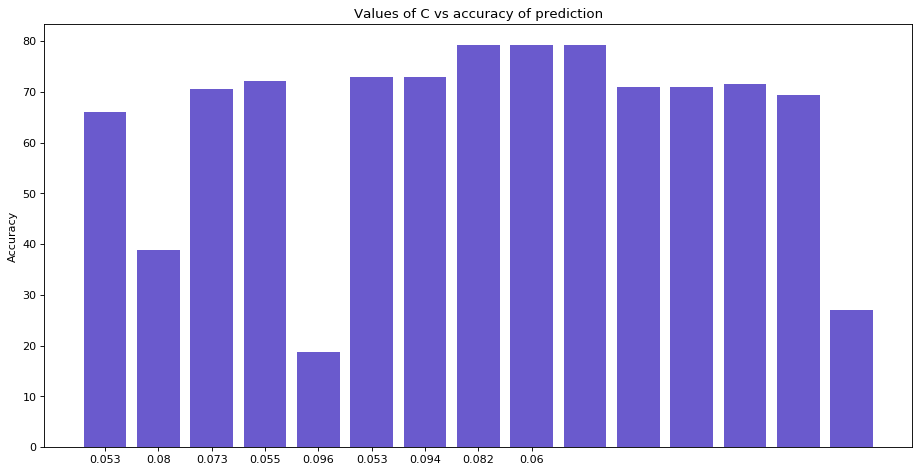

In [35]:
figure(num=None, figsize=(24, 7), dpi=80, facecolor='w', edgecolor='k')
plt.bar(x_pos, accuracies, color='mediumaquamarine')
plt.xticks(x_pos, kernels)
plt.title("Accuracy of Kernel Logistic Regression by Kernel(As a Percent)")
plt.ylabel("Accuracy")
plt.show()


X = []
Y = []
for idx,x in enumerate(C_list):
    if idx % 6 == 0:
        X.append(x[0])
        Y.append(x[1])
c_val_x_pos = [i for i, _ in enumerate(X)]

figure(num=None, figsize=(14, 7), dpi=80, facecolor='w', edgecolor='k')
plt.bar(sk_x_pos, sk_total, color='indianred')
plt.title("Accuracy of SKLearn Kernel Logistic Regression by Kernel(As a Percent)")
plt.ylabel("Accuracy")
plt.xticks(x_pos, sklearn_kernels, fontsize=18)
plt.show()

figure(num=None, figsize=(14, 7), dpi=80, facecolor='w', edgecolor='k')
plt.bar(c_val_x_pos, Y, color='slateblue')
plt.xticks(x_pos, X)
plt.title("Values of C vs accuracy of prediction")
plt.ylabel("Accuracy")
plt.show()


<h3>2.3.1 Inferences</h3>

1. The dataset appears to have a large number of local minima.
2. This is best observed with Newton's method because, for a small step size that we picked initially, the accuracy was as low as 28%.
3. Since, It is a single step method, we changed the step size to obtain an accuracy of about 80%
4. This implies that when the step size is low, the algorithm latched on to a local minimum in the cost surface.
5. To escape from this local minimum, we had to increase the step size substantially at which the point, the accuracies improved substantially.

<h3>2.3.2 Deployment</h3><br>

For deployment, I believe, we would choose Newton's method implementation of ours or Scikit learn. As the training time is substantially low compared to all the other methods while still not compromizing on the accuracy. By choosing step size carefully, and may be other intelligent ways, we can escape the local minima on the cost surface.

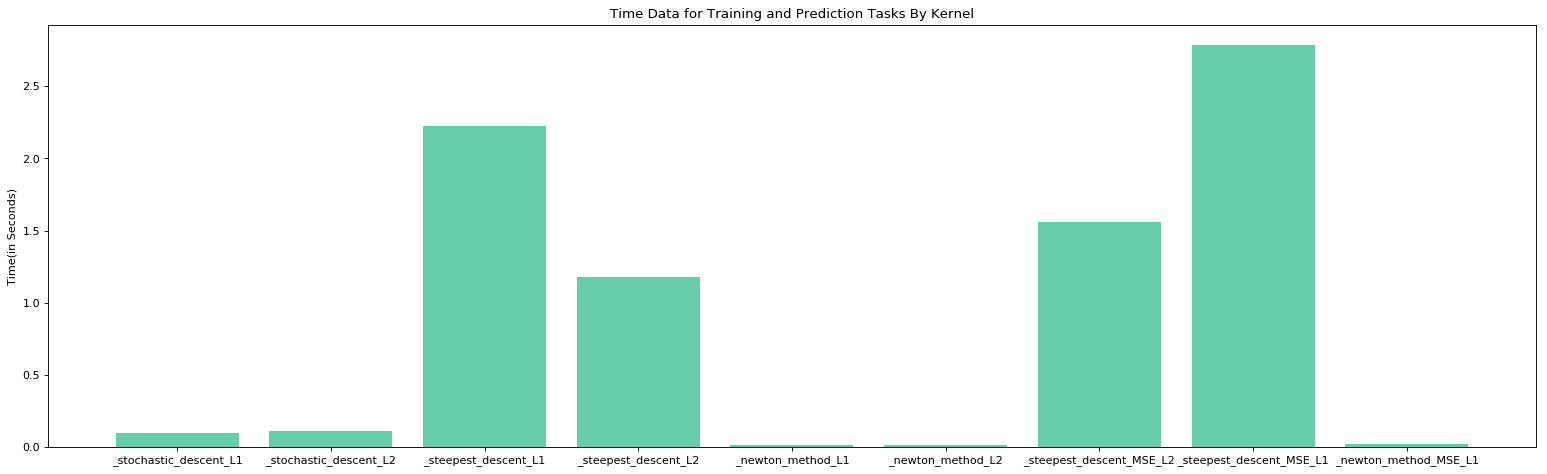

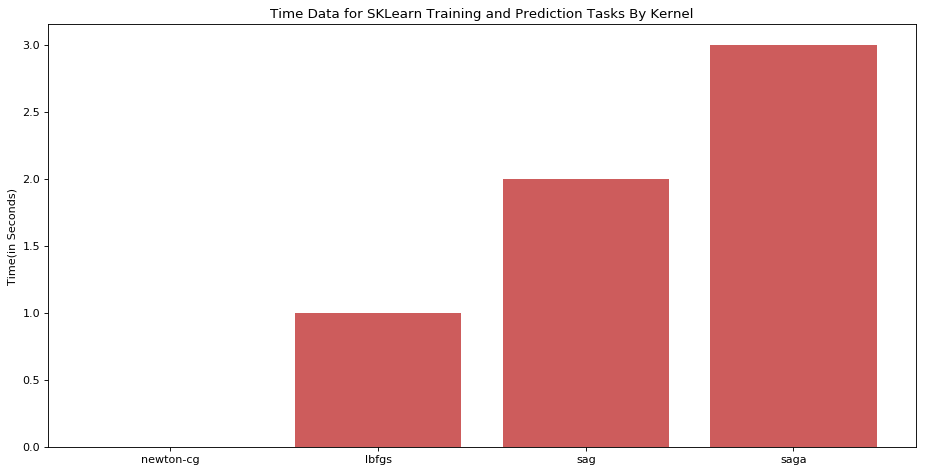

In [11]:


figure(num=None, figsize=(24, 7), dpi=80, facecolor='w', edgecolor='k')
plt.bar(x_times, times, color='mediumaquamarine')
plt.title("Time Data for Training and Prediction Tasks By Kernel")
plt.ylabel("Time(in Seconds)")
plt.xticks(x_times, kernels)
plt.show()

figure(num=None, figsize=(14, 7), dpi=80, facecolor='w', edgecolor='k')
plt.bar(sk_x_pos, sk_x_times, color='indianred')
plt.title("Time Data for SKLearn Training and Prediction Tasks By Kernel")
plt.ylabel("Time(in Seconds)")
plt.xticks(sk_x_pos, sklearn_kernels)
plt.show()


<h2> Deployment </h2>
We considered 2 major factors when deciding on a kernel for deployment. Those 2 concerns are accuracy, most importantly, and training time. In both cases, Newton's method comes out ahead as a clear winner. This is also true of the scikit learn implementations. This will allow for the training on big data, as well as accurate modeling that will best aid in the operation of the business.

<h2> Exceptional credit </h2><br></br>
Mean-Squared error cost can be defined by:

$$ l(\mathbf{w}) = \sum_{i=1}^M \mathbf{(}y_i- g(\mathbf{W}^T\mathbf{X}^{(i)})\mathbf{)}^2  $$

Derivative of the cost function is given by:

$$ \nabla l(\mathbf{w}) = -2\sum_{i=1}^M (y_i- g)[g(1 - g)]   $$

Therefore the Hessian (Second- derivative) for logistic regression becomes:
$$ \mathbf{H}_{j,k}[l(\mathbf{w})] = -\sum_{i=1}^M g[1-g][y_i-2g(1 + y_i) + 3{g}^2]{x_k}^{(i)}{x_j}^{(i)} + \underbrace{2\cdot C}_{\text{regularization}}  $$

Now we can place the Hessian derivation into the Newton Update Equation, like this:

$$ \mathbf{w} \leftarrow \mathbf{w} + \eta \cdot \underbrace{[\mathbf{X}^T\text{diag}[g[1-g][y_i-2g(1 + y_i) + 3{g}^2]]\cdot \mathbf{X}]^{-1}}_{\text{inverse Hessian}}\cdot\underbrace{\nabla l(\mathbf{w})}_{\text{gradient}}$$

Final expression becomes:

$$ \mathbf{w} \leftarrow \mathbf{w} + \eta \cdot \underbrace{[\mathbf{X}^T\text{diag}[g[1-g][y_i-2g(1 + y_i) + 3{g}^2]]\cdot \mathbf{X}]^{-1}}_{\text{inverse Hessian}}\cdot \mathbf{X}*y_{diff}*[\mathbf{g}(\mathbf{1 - g})]$$

The code is already run in earlier steps for performing regression in a single step. The accuracy is very low. It could possibly be due to the algorithm being converged to a local minima in the cost surface. For MSE cost function, it looks like the cost surface has more local minima that the cross entropy function surface and hence a reduction in accuracy.

<h2>4.0 Conclusion</h2><br>

In conclusion, the dataset that we have used seems to be classifiable using logistic regression after dimensionality reduction. The largest accuracy obtained was around 81%. It couldn't reach 100% possibly beacuse of the non-linear nature of the clusters in 3-dimensions as can be evidenced from the PCA outputs from Assignment -1.
![image.png](attachment:image.png)

<img src='image.png'>